## Image network extraction 

So, my goal here is to get structurally meaningful graph data from an image and then load it into NetworkX. I'm excited to see what it can do, but haven't had a chance to use it much yet. I've come up with two pretty simple (and probably unoriginal) methods for extracting adjacency data, which I've implemented below.

In [1]:
from IPython.display import display
import numpy as np
import networkx as nx
from networkx.algorithms import approximation as approx
import matplotlib.pyplot as plt
%matplotlib inline

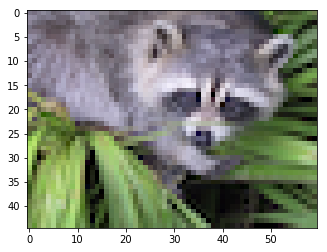

In [2]:
import skimage.io as io
from skimage.util import img_as_float
img = io.imread("face_min.png")
img = img_as_float(img)
# Strip out opacity channel
img = img[:,:,:3]
img_shape = img.shape[:2]
img_size = img.shape[0] * img.shape[1]
plt.imshow(img)
plt.show()

The first thing I'm going to try is extracting value information from the image. The algorithm takes the inverse square of the difference between every pair of pixels in the image. The result is a four-dimensional array or "image of images"

In [3]:
# Norm to value-space
alpha = np.sum(img*img, axis=2)
# Compute inverse square of difference of every pair, with squish factor to reduce error
alpha = 1 / (0.01 + np.subtract.outer(alpha, alpha) ** 2)

And here's what that looks like selecting for the top 40% most similar pixels and overlaid on the original image:

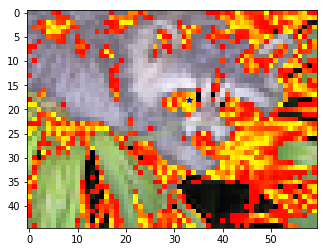

In [4]:
pt = (18, 33)
dp = alpha[pt]
dp = np.ma.masked_less(dp, np.percentile(dp, 60))
plt.imshow(img, alpha=1)
plt.imshow(dp.reshape(img_shape), alpha=1, cmap='autumn')
plt.plot(pt[1], pt[0], 'b*')
plt.show()

The other method is a little bit more complicated. Basically, it's trying to extract the hue data. Hopefully, this will complement the value method nicely. First, it transforms the color space to the median centroid of the image's profile. It then computes the norm of each pixel in the image, post-transform. Next, it takes the dot product of every pair of pixels, and finally normalizes against each via the norms it recorded before.

More intuitively, it's transforming the (0,0,0)->(1,1,1) cube of rgb color space to a hollow sphere centered at the origin, points on the surface of which represent unique, continuous, colors. It then outputs the cosine of the angular distance between each pair of pixels on the sphere as a 4D structure like above.

In [8]:
# Transform to center
beta = img - np.array(list(map(np.median, np.transpose(img, (2, 1, 0)))))
norm = np.sum(beta*beta, axis=2) ** 0.5
# Compute dot product of every pair of points
beta = np.tensordot(beta, beta, (2, 2))
# Norm to hue-space, with squish factor to reduce error
beta = beta / (norm + 0.00001)
beta = beta / (norm[:, :, np.newaxis, np.newaxis] + 0.00001)



(45, 60, 1, 1)

And here's what that looks like. It took a lot of fine-tuning to get satisfactory results, but I'm quite pleased with it now.

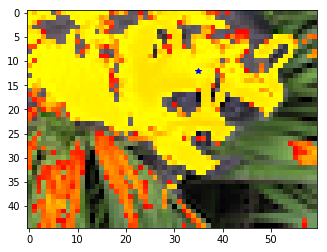

In [9]:
pt = (12, 35)
dp = beta[pt]
dp = np.ma.masked_less(dp, np.percentile(dp, 50))
plt.imshow(img)
plt.imshow(dp.reshape(img_shape), cmap='autumn')
plt.plot(pt[1], pt[0], 'b*')
plt.show()

Next we need to make a copy of both structures and flatten them into 2d matrices (rows and columns representing pixels). In theory, the extraction methods above should be transitive, but they aren't quite in practice, so we should also enforce symmetry now.

Finally, the matrices can be pruned from floats to binary adjacency given some threshold. I decided to prune them pretty agressively, cutting out 90% of edges so the result wouldn't be so dense. This threshold can be raised or lowered as needed.

In [5]:
alpha_pruned = alpha.copy()
# Rearrange into an adjacency matrix
alpha_pruned = alpha.reshape(img_size, img_size)
# Force symmetry
alpha_pruned = np.maximum(alpha_pruned, alpha_pruned.T)
# Prune weak edges
alpha_pruned[alpha_pruned < np.percentile(alpha_pruned, 90)] = 0
alpha_pruned[alpha_pruned > 0] = 1

In [10]:
beta_pruned = beta.copy()
# Rearrange into an adjacency matrix
beta_pruned = beta_pruned.reshape(img_size, img_size)
# Force symmetry
beta_pruned = np.maximum(beta_pruned, beta_pruned.T)
# Prune weak edges
beta_pruned[beta_pruned < np.percentile(beta_pruned, 90)] = 0
beta_pruned[beta_pruned > 0] = 1

And here's what the two methods look like. All of the neighbors of a single (blue) pixel are highlighted in red in each image.

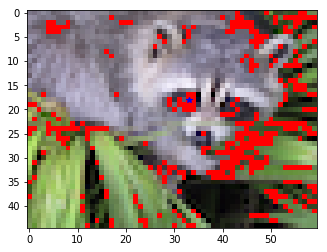

In [6]:
pt = (18, 33)
dp = alpha_pruned[(pt[0] * img.shape[1] + pt[1])]
dp = np.ma.masked_less(dp, 0.1)
plt.imshow(img)
plt.imshow(dp.reshape(img_shape), cmap='autumn')
plt.plot(pt[1], pt[0], 'b*')
plt.show()

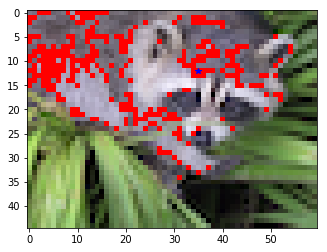

In [11]:
pt = (12, 35)
dp = beta_pruned[(pt[0] * img.shape[1] + pt[1])]
dp = np.ma.masked_less(dp, 0.1)
plt.imshow(img)
plt.imshow(dp.reshape(img_shape), cmap='autumn')
plt.plot(pt[1], pt[0], 'b*')
plt.show()

And finally we have adjacency matrices ready to be imported into NetworkX:

In [20]:
A = nx.Graph(alpha_pruned)
A.name = 'A'
print(nx.info(A))

Name: A
Type: Graph
Number of nodes: 2700
Number of edges: 365854
Average degree: 271.0030


In [18]:
B = nx.Graph(beta_pruned)
B.name = 'B'
print(nx.info(B))

Name: B
Type: Graph
Number of nodes: 2700
Number of edges: 365850
Average degree: 271.0000
